# Kaggle - Link prediction - Notebook

Authors: Emma Gauillard, Théo Guilbert, Martin Lefèvre, Guillaume Grasset-Gothon

### For Google Collab

In [1]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/
#####################################################
# import torch


# def format_pytorch_version(version):
#     return version.split("+")[0]


# TORCH_version = torch.__version__
# TORCH = format_pytorch_version(TORCH_version)


# def format_cuda_version(version):
#     return "cu" + version.replace(".", "")


# CUDA_version = torch.version.cuda
# CUDA = format_cuda_version(CUDA_version)

# !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-geometric

In [1]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv, SAGEConv
from torch_geometric.loader import NeighborLoader, LinkNeighborLoader, LinkLoader, NodeLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

import random
import networkx as nx
import tqdm
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import prince

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1 - Graph Implementation

In [503]:
csv_file = "node_information.csv"
node_information = pd.read_csv(csv_file, header=None)
node_information.rename(columns={0: "node_id"}, inplace=True)
node_information.shape

(3597, 933)

In [3]:
node_information = pd.read_csv('node_information.csv', header=None, index_col=0)
train_set = pd.read_csv('train.txt', header=None, sep=' ')
train_set.columns = ['node1', 'node2', 'connected']
test_set = pd.read_csv('test.txt', header=None, sep=' ')
test_set.columns = ['node1', 'node2']

mapping = {node_information.index[i]: i for i in range(len(node_information))}
node_information.index = node_information.index.map(mapping)
train_set["node1"] = train_set["node1"].map(mapping)
train_set["node2"] = train_set["node2"].map(mapping)
test_set["node1"] = test_set["node1"].map(mapping)
test_set["node2"] = test_set["node2"].map(mapping)

In [4]:
train_set

,node1,node2,connected
0,510,1991,1
1,1308,2872,1
2,100,1991,1
3,466,1221,1
4,723,2846,1
...,...,...,...
10491,44,3176,0
10492,1,3159,0
10493,1767,3272,1
10494,840,2385,0


In [5]:
# combien de samples positifs et négatifs
pos = len(train_set[train_set['connected'] == 1])
neg = len(train_set[train_set['connected'] == 0])
print(f"Positif: {pos}")
print(f"Negatif: {neg}")

Positif: 5248
Negatif: 5248


In [6]:
connected_edges = train_set[train_set['connected'] == 1]
training_graph = nx.from_pandas_edgelist(connected_edges, source='node1', target='node2', create_using=nx.Graph())
plt.figure(figsize=(5,5))

# nx.draw(training_graph, node_size = 5, alpha = 0.2, width = 0.6)

plt.show()

<Figure size 500x500 with 0 Axes>

In [7]:
# create test samples
test_samples = [tuple((element[0], element[1])) for element in test_set.values]
# create train and val samples
samples = list(zip(train_set['node1'], train_set['node2']))
labels = train_set['connected']
train_samples, val_samples, train_labels, val_labels = train_test_split(samples, labels, test_size=0.2, random_state=42)

# Afficher la taille des ensembles
print("Nombre d'échantillons d'entraînement :", len(train_samples))
print("Nombre d'échantillons de validation :", len(val_samples))

# Repartition des labels dans val et train
print("Nombre de labels positifs dans l'ensemble d'entraînement :", sum(train_labels))
print("Nombre de labels positifs dans l'ensemble de validation :", sum(val_labels))


Nombre d'échantillons d'entraînement : 8396
Nombre d'échantillons de validation : 2100
Nombre de labels positifs dans l'ensemble d'entraînement : 4207
Nombre de labels positifs dans l'ensemble de validation : 1041


In [8]:
def remove_val_edges(graph,val_samples):
    """
    Remove edges from validation set before computing
    """
    if nx.is_connected(graph) is not True:
        raise ValueError("The graph contains more than one connected component!")

    residual_g = graph.copy()

    # Shuffle the list of edges
    edges = list(residual_g.edges())

    for (source, target) in val_samples:
        if residual_g.has_edge(source, target):
            residual_g.remove_edge(source, target)

    return residual_g

residual_g = remove_val_edges(training_graph, val_samples)

In [9]:
residual_edges = list(residual_g.edges())
assert len(residual_edges) == sum(train_labels)

In [10]:
# nx.draw(residual_g, node_size = 5, alpha = 0.2, width = 0.6)

# 2 - Feature Engineering

## 2.1 - Feature Selection

In [11]:
explained_variance_mca = []
explained_variance_pca = []
nb_comp = []
for i in range(100, node_information.shape[1], 50):
  print(i)
  mca = prince.MCA(n_components=i)
  mca.fit(node_information)
  explained_variance_mca.append(mca.eigenvalues_summary["% of variance"].sum())

  pca = PCA(n_components=i)
  pca.fit(node_information)
  explained_variance_pca.append(pca.explained_variance_ratio_.sum())
  nb_comp.append(i)

for i in range(len(explained_variance_mca)):
  explained_variance_mca[i] = np.array(explained_variance_mca[i].split("%")[:-1]).astype(float).sum()

fig, axs = plt.subplots(1,2, figsize=(15,5))

axs[0].plot(nb_comp, explained_variance_mca)
axs[0].set_title("Explained variance MCA")
axs[0].set_xlabel("Number of components")
axs[0].set_ylabel("% of variance explained")

axs[1].plot(nb_comp, explained_variance_pca)
axs[1].set_title("Explained variance PCA")
axs[1].set_xlabel("Number of components")
axs[1].set_ylabel("% of variance explained")

fig.suptitle("Dimensionality reduction methods")

plt.show()

100


150
200
250
300


KeyboardInterrupt: 

## 2.2 - Node Features

- **Degree Centrality**: Degree centrality of a node is the fraction of nodes it is connected to. It quantifies how central a node is within a network.
- **Betweenness Centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through that node. It measures the influence of a node over the flow of information between pairs of nodes.
- **PageRank Centrality**: PageRank centrality assigns a score to each node based on the structure of incoming links to that node. It measures the importance of a node based on the importance of nodes linking to it.
- **Closeness Centrality**: Closeness centrality of a node is the reciprocal of the sum of the shortest path distances from the node to all other nodes in the network. It quantifies how close a node is to all other nodes in the network.
- **Eigenvector Centrality**: Eigenvector centrality measures the influence of a node in a network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question. It quantifies the relative importance of a node in the network.
- **Triangles**: Triangles of a node count the number of triangles that the node is part of. It measures the extent of clustering around a node, indicating the presence of tightly knit communities.
- **k-core**: The k-core to identify the core structure of a network. It is a maximal subgraph in which every vertex is of degree at least k within that subgraph. 



In [12]:
def add_degree_centrality_to_features(residual_g, train_samples, val_samples,test_samples, node_information, ):
  deg_centrality = nx.degree_centrality(residual_g)
  every_samples = train_samples + val_samples + test_samples
  for edge in tqdm.tqdm(every_samples):
      source_node, target_node = edge[0], edge[1]
      # Degree Centrality
      node_information.at[source_node, 'degree_centrality'] = deg_centrality[source_node]
      node_information.at[target_node, 'degree_centrality'] = deg_centrality[target_node]
    
  return node_information

In [13]:
def add_eigenvectors_to_features(residual_g, train_samples, val_samples,test_samples, node_information):
  betweeness_centrality = nx.betweenness_centrality(residual_g)
  every_samples = train_samples + val_samples + test_samples
  for edge in tqdm.tqdm(every_samples):
      source_node, target_node = edge[0], edge[1]
      # Betweeness Centrality
      node_information.at[source_node, 'betweenness_centrality'] = betweeness_centrality[source_node]
      node_information.at[target_node, 'betweenness_centrality'] = betweeness_centrality[target_node]
  return node_information

In [14]:
def add_eigenvectors_to_features(residual_g, train_samples, val_samples,test_samples, node_information):
  pagerank_centrality = nx.pagerank(residual_g)
  every_samples = train_samples + val_samples + test_samples
  for edge in tqdm.tqdm(every_samples):
      source_node, target_node = edge[0], edge[1]
      # PageRank Centrality
      node_information.at[source_node, 'pagerank_centrality'] = pagerank_centrality[source_node]
      node_information.at[target_node, 'pagerank_centrality'] = pagerank_centrality[target_node]
  return node_information

In [15]:
def add_pagerank_to_features(residual_g, train_samples, val_samples,test_samples, node_information):
  pagerank_centrality = nx.pagerank(residual_g)
  every_samples = train_samples + val_samples + test_samples
  for edge in tqdm.tqdm(every_samples):
      source_node, target_node = edge[0], edge[1]
      # PageRank Centrality
      node_information.at[source_node, 'pagerank_centrality'] = pagerank_centrality[source_node]
      node_information.at[target_node, 'pagerank_centrality'] = pagerank_centrality[target_node]
  return node_information

In [16]:
def add_closeness_centrality_to_features(residual_g, train_samples, val_samples,test_samples, node_information):
  closeness_centrality = nx.closeness_centrality(residual_g)
  every_samples = train_samples + val_samples + test_samples
  for edge in tqdm.tqdm(every_samples):
      source_node, target_node = edge[0], edge[1]
      # Closeness Centrality
      node_information.at[source_node, 'closeness_centrality'] = closeness_centrality[source_node]
      node_information.at[target_node, 'closeness_centrality'] = closeness_centrality[target_node]
  return node_information

In [17]:
def add_eigenvectors_to_features(residual_g, train_samples, val_samples,test_samples, node_information):
  eigenvector_centrality = nx.eigenvector_centrality(residual_g)
  every_samples = train_samples + val_samples + test_samples
  for edge in tqdm.tqdm(every_samples):
      source_node, target_node = edge[0], edge[1]
      # Eigenvector Centrality
      node_information.at[source_node, 'eigenvector_centrality'] = eigenvector_centrality[source_node]
      node_information.at[target_node, 'eigenvector_centrality'] = eigenvector_centrality[target_node]
  return node_information

In [18]:
def add_triangle_to_features(residual_g, train_samples, val_samples,test_samples, node_information):
  triangles = nx.triangles(residual_g)
  every_samples = train_samples + val_samples + test_samples
  for edge in tqdm.tqdm(every_samples):
      source_node, target_node = edge[0], edge[1]
      # Triangles
      node_information.at[source_node, 'triangles'] = triangles[source_node]
      node_information.at[target_node, 'triangles'] = triangles[target_node]
  return node_information

In [19]:
def add_kcore_number_to_features(residual_g, train_samples, val_samples,test_samples, node_information):
  residual_g_copy = residual_g.copy()
  residual_g_copy.remove_edges_from(nx.selfloop_edges(residual_g_copy))
  kcore = nx.core_number(residual_g_copy)
  node_information['kcore'] = 0
  every_samples = train_samples + val_samples + test_samples
  for edge in tqdm.tqdm(every_samples):
      source_node, target_node = edge[0], edge[1]
      # kcore
      node_information.at[source_node, 'kcore'] = kcore[source_node]
      # Attribution kcore number au nœud cible
      node_information.at[target_node, 'kcore'] = kcore[target_node]
  return node_information

In [504]:
# Add features residuals

node_information_residual = node_information.copy()
node_information_residual = add_degree_centrality_to_features(residual_g, train_samples, val_samples,test_samples, node_information)
node_information_residual = add_eigenvectors_to_features(residual_g, train_samples, val_samples,test_samples, node_information)
node_information_residual = add_pagerank_to_features(residual_g, train_samples, val_samples,test_samples, node_information)
node_information_residual = add_closeness_centrality_to_features(residual_g, train_samples, val_samples,test_samples, node_information)
node_information_residual = add_eigenvectors_to_features(residual_g, train_samples, val_samples,test_samples, node_information)
node_information_residual = add_triangle_to_features(residual_g, train_samples, val_samples,test_samples, node_information)
node_information_residual = add_kcore_number_to_features(residual_g, train_samples, val_samples,test_samples, node_information)

IndexError: positional indexers are out-of-bounds

In [21]:

node_information_training = node_information.copy()
node_information_training = add_degree_centrality_to_features(training_graph, train_samples, val_samples,test_samples, node_information)
node_information_training = add_eigenvectors_to_features(training_graph, train_samples, val_samples,test_samples, node_information)
node_information_training = add_pagerank_to_features(training_graph, train_samples, val_samples,test_samples, node_information)
node_information_training = add_closeness_centrality_to_features(training_graph, train_samples, val_samples,test_samples, node_information)
node_information_training = add_eigenvectors_to_features(training_graph, train_samples, val_samples,test_samples, node_information)
node_information_training = add_triangle_to_features(training_graph, train_samples, val_samples,test_samples, node_information)
node_information_training = add_kcore_number_to_features(training_graph, train_samples, val_samples,test_samples, node_information)

  0%|          | 0/13994 [00:00<?, ?it/s]

100%|██████████| 13994/13994 [00:00<00:00, 23176.79it/s]


### Add community features

- **Community Detection**: Community detection algorithms in order to identify densely connected groups of nodes in a network, known as communities or clusters. These algorithms help uncover the underlying structure and organization of complex networks.

In [22]:
def spectral_clustering(G, k):
    '''
    :param G: given graph
    :param k: the number of clusters
    :return partition: a list of node sets where each node set indicates a cluster
    '''
    A = nx.to_numpy_array(G)
    D = np.diag(np.sum(A, axis=1))
    L = D - A
    eigvals, eigvecs = np.linalg.eigh(L)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(eigvecs[:, :k])
    partition = []
    for i in range(k):
        partition.append(set(np.where(kmeans.labels_ == i)[0].astype(str)))
            
    return tuple(partition)

In [23]:
def girvan_newman_algorithm(G):
    '''
    :param G: given graph
    :return partitions: a list tuples of sets of nodes in the graph. Each node set indicates a community and
    each tuple is a sequence of communities at a certain level of the algorithm.
    '''
    g = G.copy()
    partitions = []

    while True:
        betweenness = nx.edge_betweenness_centrality(g)
        max_edge = max(betweenness, key=betweenness.get)
        g.remove_edge(*max_edge)
        tuple_component = []
        for component in nx.connected_components(g):
            # component = {float(node) for node in component}
            tuple_component.append(component)

        partitions.append(tuple(tuple_component))
        if g.number_of_edges() == 0:
            break

    return pd.Series(partitions).drop_duplicates().tolist()

In [24]:
def compute_modularity(G, partition):
    '''
    :param G: given graph
    :param partition: a tuple of node sets.
    :return result: modularity value for a given partition of the network.
    '''
    Q = 0
    m = G.number_of_edges()
    A = nx.to_numpy_array(G)
    for nodes_u in G.nodes():
        group_u = [i for i, part in enumerate(partition) if str(nodes_u) in part][0]
        for nodes_v in G.nodes():
            group_v = [i for i, part in enumerate(partition) if str(nodes_v) in part][0]
            if group_u == group_v:
                Q += (A[int(nodes_u)][int(nodes_v)] - G.degree(nodes_u) * G.degree(nodes_v) / (2 * m))
    
    result = Q / (2 * m)

    return result

In [25]:
# Combine both girvan_newman_algorithm or spectral clustering and modularity to find the best community partition
def best_community(G, partitions):
    '''
    :param G: given graph
    :param partitions: a list of tuples of sets of nodes in the graph. Each node set indicates a community and
    each tuple is a sequence of communities at a certain level of the algorithm.
    :return best_partition: the best partition of the network based on modularity score.
    '''
    best_partition = partitions[0]
    best_modularity = compute_modularity(G, best_partition)
    for partition in partitions[1:]:
        modularity = compute_modularity(G, partition)
        if modularity > best_modularity:
            best_modularity = modularity
            best_partition = partition

    return best_partition

In [26]:
def add_community_to_features(graph, node_information, method):
  node_information['community'] = 0

  if method == "girvan":
    partitions = girvan_newman_algorithm(graph)
    best_commu = best_community(graph, partitions)
  elif method == "spectral":
    # partitions = [spectral_clustering(graph, k) for k in [10, 30, 50, 100, 200, 400, 500, 600, 800, 1000]]
    partitions = [spectral_clustering(graph, k) for k in range(2, 10)]
    best_commu = best_community(graph, partitions)
  
  print("Number of communities:", len(best_commu))

  for i, community in enumerate(best_commu):
      for node in community:
          node_information.at[int(node), 'community'] = i
  
  comunity_features = pd.get_dummies(node_information["community"]).map(lambda x: 1 if x else 0)
  comunity_features.columns = ["community_" + str(i) for i in comunity_features.columns]
  node_information = pd.concat([node_information, comunity_features], axis=1)
  node_information.drop("community", axis=1, inplace=True)

  return node_information

In [27]:
# node_information = add_community_to_features(residual_g, node_information, method="spectral")

## 2.3 - Edge Feature

In [587]:
def feature_extractor(graph, samples, node_information, node_information_bool = False):
    """
    Creates a feature vector for each edge of the graph contained in samples
    """
    print("Computing betweenness for each edge")
    # betweeness_centrality = nx.betweenness_centrality(graph)
    print("Computing degree centrality for each edge")
    deg_centrality = nx.degree_centrality(graph)
    feature_edge_vector = []
    for edge in tqdm.tqdm(samples):
        source_node, target_node = edge[0], edge[1]
        # Degree Centrality
        # diff_deg = deg_centrality[source_node] - deg_centrality[target_node]


        # Betweeness centrality  
        # diff_bt = betweeness_centrality[source_node] - betweeness_centrality[target_node]

        # Preferential Attachement
        if source_node not in graph or target_node not in graph:
            pref_attach = 0
        else:
            pref_attach = list(nx.preferential_attachment(graph, [(source_node, target_node)]))[0][2]

        # AdamicAdar
        if source_node not in graph or target_node not in graph:
            aai = 0
        else:
            aai = sum(1 / np.log(graph.degree(z)) for z in nx.common_neighbors(graph, source_node, target_node) if np.log(graph.degree(z)) != 0)
        # Compute the Jaccard coefficient
        if source_node not in graph or target_node not in graph:
            jacard_coeff = 0
        else:
            neighbords_source, neighbord_target = set(graph.neighbors(source_node)), set(graph.neighbors(target_node))
            inter = len(neighbords_source.intersection(neighbord_target))
            union = len(neighbords_source.union(neighbord_target))
            if union == 0:
                jacard_coeff = 0
            else:
                jacard_coeff = inter/union
        
        # Cosine similarity
        # if source_node not in graph or target_node not in graph:
        #     cosine_sim = 0
        # else:
        #     neighbords_source, neighbord_target = set(graph.neighbors(source_node)), set(graph.neighbors(target_node))
        #     inter = len(neighbords_source.intersection(neighbord_target))
        #     if (np.sqrt(len(neighbords_source) * len(neighbord_target))) != 0:
        #       cosine_sim = inter / (np.sqrt(len(neighbords_source) * len(neighbord_target)))
        #     else:

        #       cosine_sim = 0
        # # Shortest path
        # if source_node not in graph or target_node not in graph:
        #     shortest_path = 0
        # else:
        #     try:
        #         shortest_path = nx.shortest_path_length(graph, source_node, target_node)
        #         if np.isinf(shortest_path):
        #           print('inf short')
        #           shortest_path = 0
        #     except:
        #         shortest_path = -1
            
        feature_edge_metrics = np.array([pref_attach, aai, jacard_coeff])


        if node_information_bool:
            indice_relevant_nodes = [1192,  933, 1201, 1817, 1209, 1202, 1026, 1211, 1862,   99,    0,
       1251, 1694, 1457,  800, 1647, 1382,  109, 1544, 1280, 1128,  741,
        285,  796, 1287, 1648, 1563, 1140, 1348, 1197] + [node_information.shape[1]//2 - i for i in range(1,7)]  + [node_information.shape[1] - i for i in range(1,7)]
            source_node_information = list(node_information.loc[int(source_node)][:])
            target_node_information = list(node_information.loc[int(target_node)][:])
            feature_node = np.concatenate([ source_node_information, target_node_information])
            # Create edge feature vector with all metric computed above
            feature_vector = np.concatenate([ feature_node,feature_edge_metrics ])[indice_relevant_nodes]
            # 42 length feature vector
            indice_relevant_feature = [41, 39, 36, 38,  2, 37, 40,  1]
            feature_edge_vector.append(feature_vector[indice_relevant_feature]) 

        else:
            feature_edge_vector.append(feature_edge_metrics)

    return np.array(feature_edge_vector)

In [588]:
# --- Create feature vector for all edges in training set and val set --- use residual
train_features_residual = feature_extractor(residual_g, train_samples, node_information_residual, node_information_bool=True)
val_features_residual = feature_extractor(residual_g, val_samples, node_information_residual, node_information_bool=True)

Computing betweenness for each edge
Computing degree centrality for each edge


100%|██████████| 8396/8396 [00:20<00:00, 414.52it/s]


Computing betweenness for each edge
Computing degree centrality for each edge


100%|██████████| 2100/2100 [00:05<00:00, 375.32it/s]


In [589]:
# --- Create feature vector for all edges in training set and val set --- use residual
train_features = feature_extractor(residual_g, train_samples, node_information_training, node_information_bool  = True)
test_features = feature_extractor(training_graph, test_samples, node_information_training, node_information_bool = True)

Computing betweenness for each edge
Computing degree centrality for each edge


100%|██████████| 8396/8396 [00:19<00:00, 430.50it/s]


Computing betweenness for each edge
Computing degree centrality for each edge


100%|██████████| 3498/3498 [00:10<00:00, 346.12it/s]


In [578]:
# 

# 3 - Model Tuning and Comparison

In [590]:
def compute_metrics(labels,preds):
    
    accuracy = accuracy_score(labels,preds)
    precision = precision_score(labels,preds)
    recall = recall_score(labels,preds)
    f1 = f1_score(labels,preds)
    roc_auc = roc_auc_score(labels,preds)
    # Confusion matrix
    conf_matrix = confusion_matrix(labels,preds)

    # Display the metrics
    print(' Set Metrics:')
    print("Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 Score: {:.3f}, ROC AUC: {:.3f}".format(
        accuracy, precision, recall, f1, roc_auc))
        
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)  # for label size
    sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])

    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()



In [591]:
def plot_roc_curve(fpr, tpr, roc_auc, title):
    """
    Plots ROC curve for a given set of false positive rates, true positive rates, and AUC.
    """
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.xticks([0, 0.5, 1])
    plt.yticks([0, 0.5, 1])
    plt.show()

In [598]:
def prediction( model , train_features, train_labels, val_features, val_labels = None):
    """
    Downstream ML task using edge embeddings to classify them 
    """
    
    # --- Build the model and train it ---
    model.fit(train_features, train_labels)
    train_preds = model.predict(train_features)
    val_preds =  model.predict(val_features)#

     # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    fpr_train, tpr_train, _ = roc_curve(train_labels, train_preds)
    roc_auc_train = auc(fpr_train, tpr_train)


    plot_roc_curve(fpr_train, tpr_train, roc_auc_train, 'Receiver Operating Characteristic Curve for training set')

    if val_labels is not None:
        print("Accuracy: ", accuracy_score(val_labels, val_preds))
        print("Precision: ", precision_score(val_labels, val_preds))
        print("Recall: ", recall_score(val_labels, val_preds))
        print("F1: ", f1_score(val_labels, val_preds))
        print("Confusion matrix: ", confusion_matrix(val_labels, val_preds))
        # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
        fpr_val, tpr_val, _ = roc_curve(val_labels, val_preds)
        roc_auc_val = auc(fpr_val, tpr_val)
        
        plot_roc_curve(fpr_val, tpr_val, roc_auc_val, 'Receiver Operating Characteristic Curve for validation set')

    # Plotting feature importances if available
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        indices = np.argsort(feature_importances)[::-1]
        feature_names = [f'Feature {i}' for i in range(len(feature_importances))]
        feature_names = list(np.array(feature_names)[indices])

        k = min(30, len(feature_importances))
        plt.figure(figsize=(10, 6))
        plt.title("Feature importances")
        plt.bar(range(k), feature_importances[indices][:k],
                color="r", align="center")
        plt.xticks(range(k), feature_names[:k], rotation='vertical')
        plt.xlim([-1, k])
        plt.show()

    return train_preds, val_preds

## 3.1 - Logistic Regression

In [494]:
lr = LogisticRegression()


c:\Users\Guillaume\anaconda3\envs\mlns\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


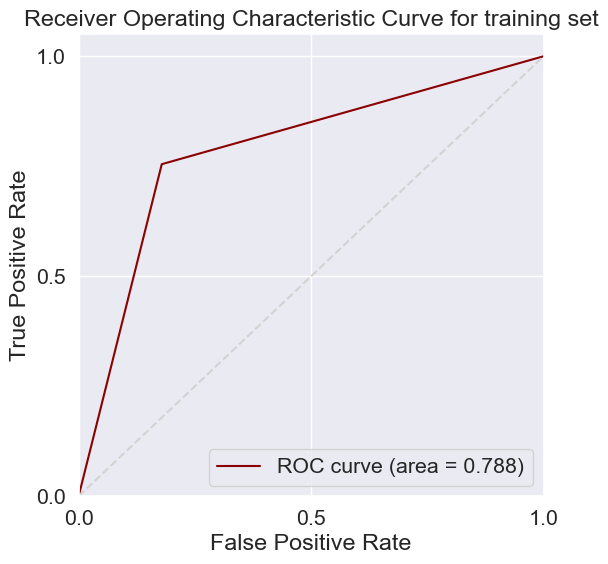

Accuracy:  0.7095238095238096
Precision:  0.7114818449460255
Recall:  0.696445725264169
F1:  0.7038834951456311
Confusion matrix:  [[765 294]
 [316 725]]


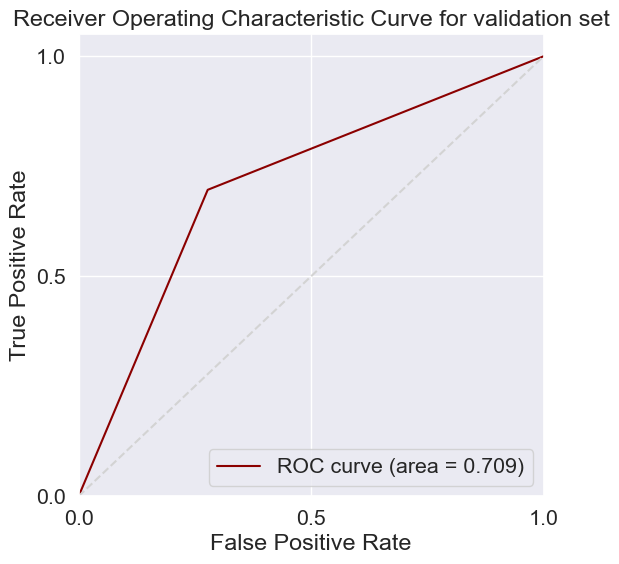

In [ ]:
train_preds, val_preds = prediction( lr , train_features_residual, train_labels, val_features_residual, val_labels)

Training
 Set Metrics:
Accuracy: 0.788, Precision: 0.809, Recall: 0.755, F1 Score: 0.781, ROC AUC: 0.788


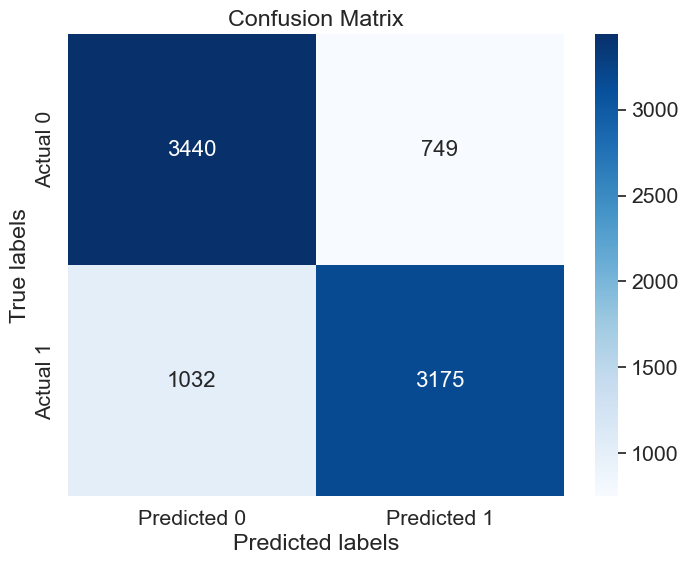

Validation
 Set Metrics:
Accuracy: 0.710, Precision: 0.711, Recall: 0.696, F1 Score: 0.704, ROC AUC: 0.709


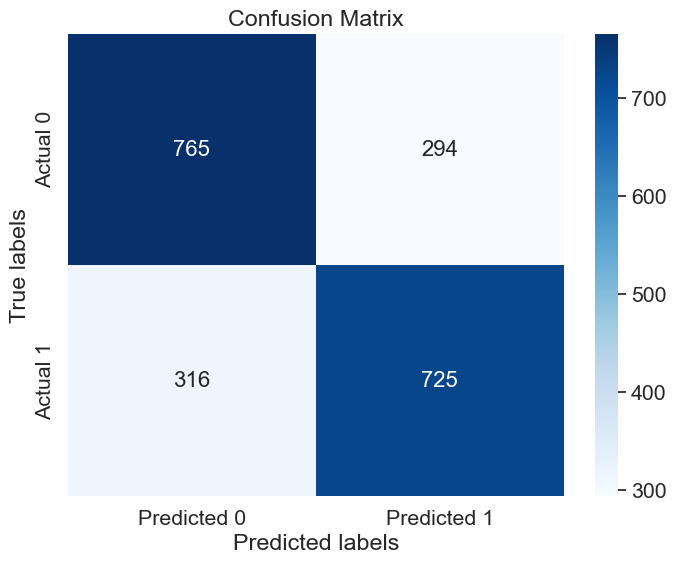

In [ ]:
print('Training')
compute_metrics(train_labels,train_preds)
print('Validation')
compute_metrics(val_labels,val_preds)

c:\Users\Guillaume\anaconda3\envs\mlns\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


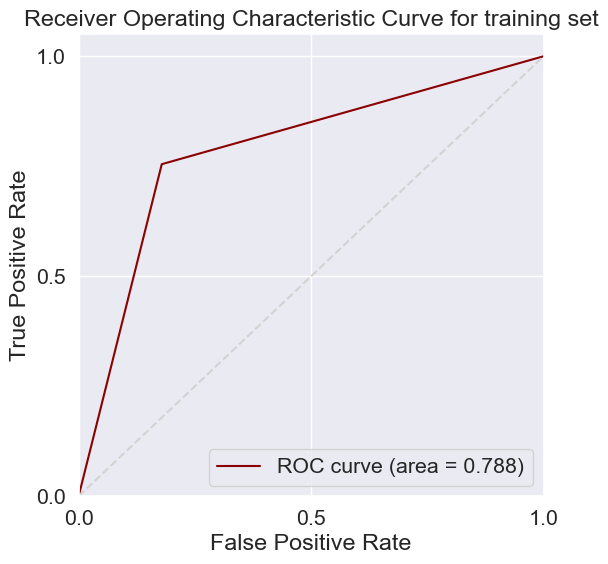

In [ ]:
# --- Link prediction ---
train_preds, test_preds = prediction(lr,train_features,train_labels, test_features)
logistic_pred = zip(np.array(range(len(test_set))), test_preds)
with open('./Predictions/LogisticRegression.csv',"w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in logistic_pred:
         csv_out.writerow(row)
    pred.close()

## 3.2 - Random Forest

In [599]:

# Model Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

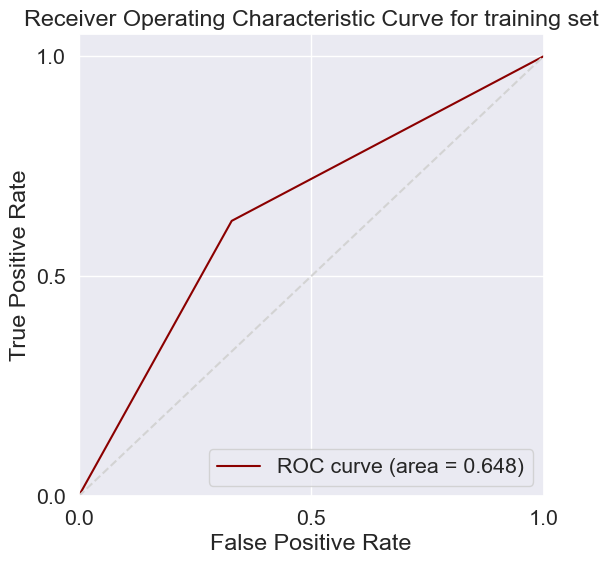

Accuracy:  0.6504761904761904
Precision:  0.6527363184079602
Recall:  0.6301633045148896
F1:  0.6412512218963832
Confusion matrix:  [[710 349]
 [385 656]]


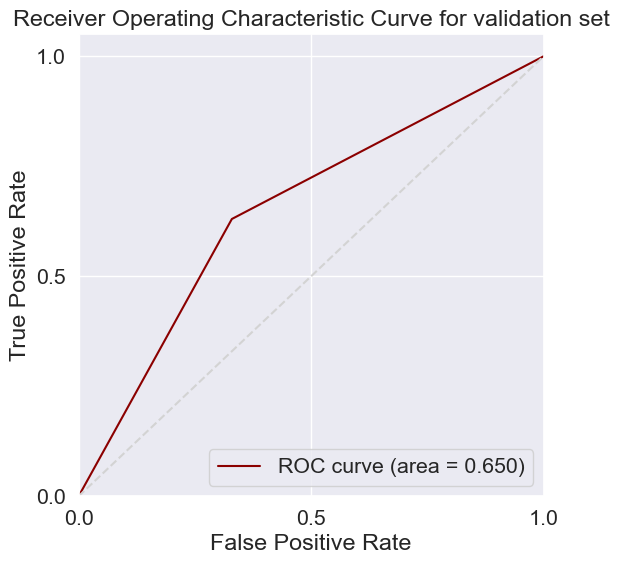

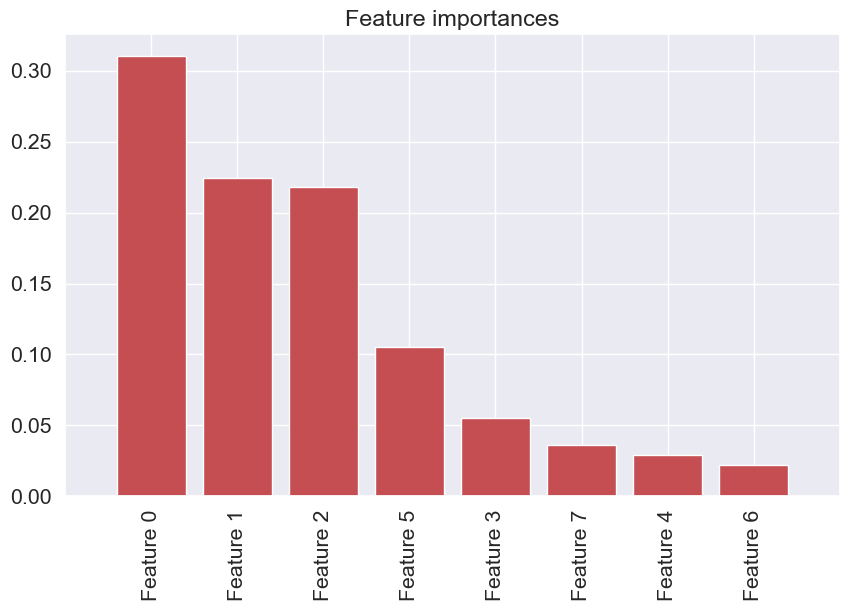

In [600]:
train_preds, val_preds = prediction( rf , train_features_residual, train_labels, val_features_residual, val_labels)

Training
 Set Metrics:
Accuracy: 0.648, Precision: 0.656, Recall: 0.626, F1 Score: 0.641, ROC AUC: 0.648


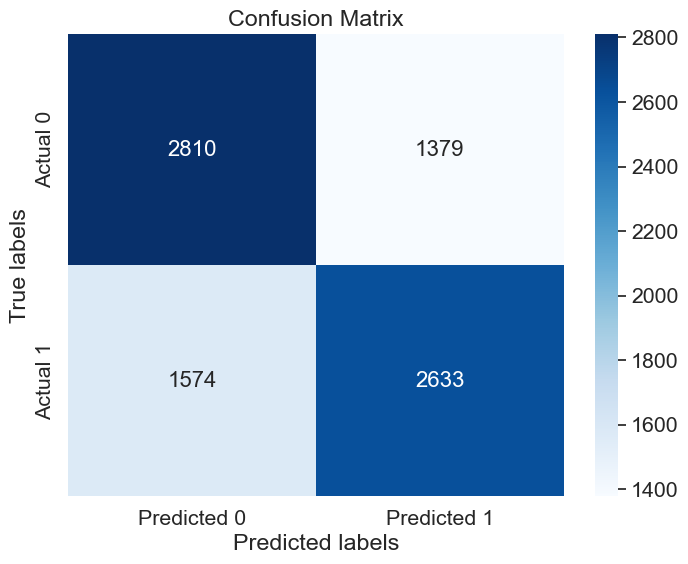

Validation
 Set Metrics:
Accuracy: 0.650, Precision: 0.653, Recall: 0.630, F1 Score: 0.641, ROC AUC: 0.650


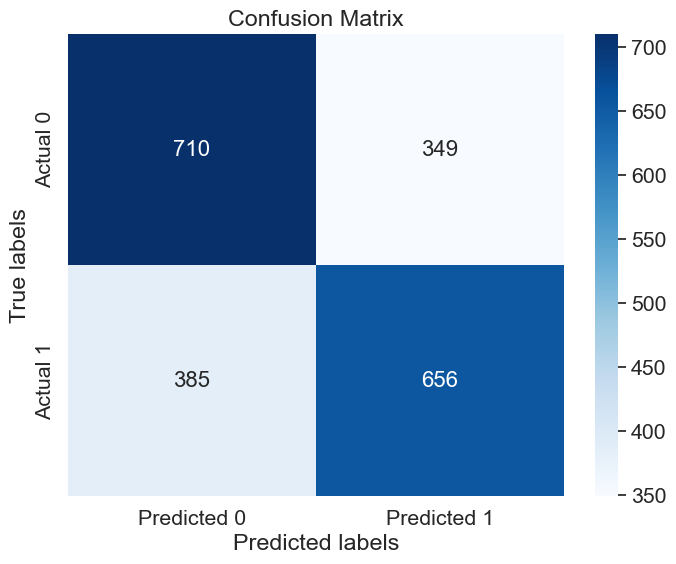

In [602]:
print('Training')
compute_metrics(train_labels,train_preds)
print('Validation')
compute_metrics(val_labels,val_preds)

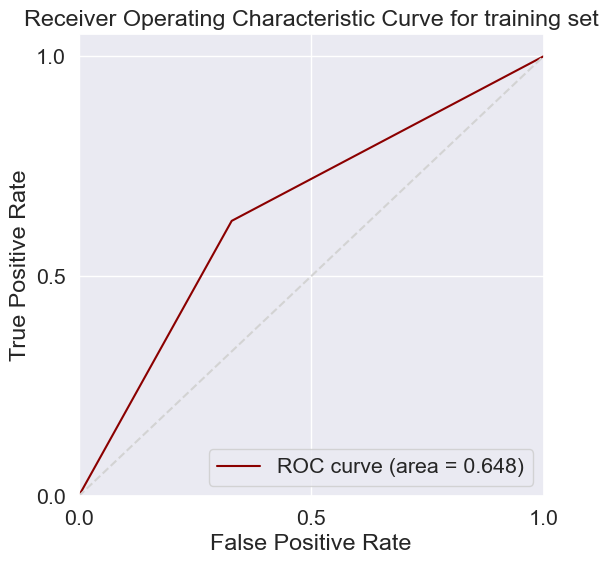

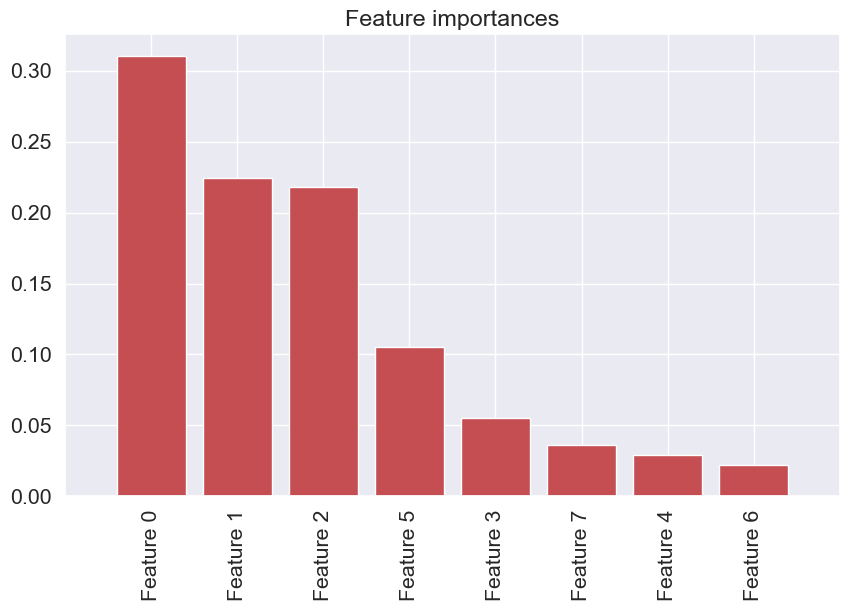

In [603]:
# --- Link prediction ---
train_preds, test_preds = prediction(rf,train_features,train_labels, test_features)
logistic_pred = zip(np.array(range(len(test_set))), test_preds)
with open('./Predictions/RandomForest.csv',"w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in logistic_pred:
         csv_out.writerow(row)
    pred.close()

## 3.3 - SVM

### 3.3 - SVM Linear

In [469]:
# Model SVC
svm_l= SVC(kernel='linear')

In [470]:
train_preds, val_preds = prediction( svm_l , train_features_residual, train_labels, val_features_residual, val_labels)

KeyboardInterrupt: 

Training
 Set Metrics:
Accuracy: 0.744, Precision: 0.851, Recall: 0.594, F1 Score: 0.699, ROC AUC: 0.745


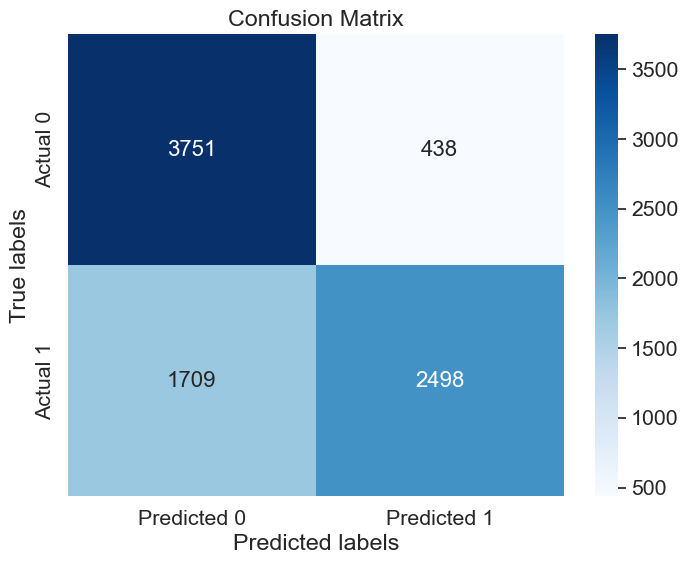

Validation
 Set Metrics:
Accuracy: 0.655, Precision: 0.798, Recall: 0.406, F1 Score: 0.539, ROC AUC: 0.653


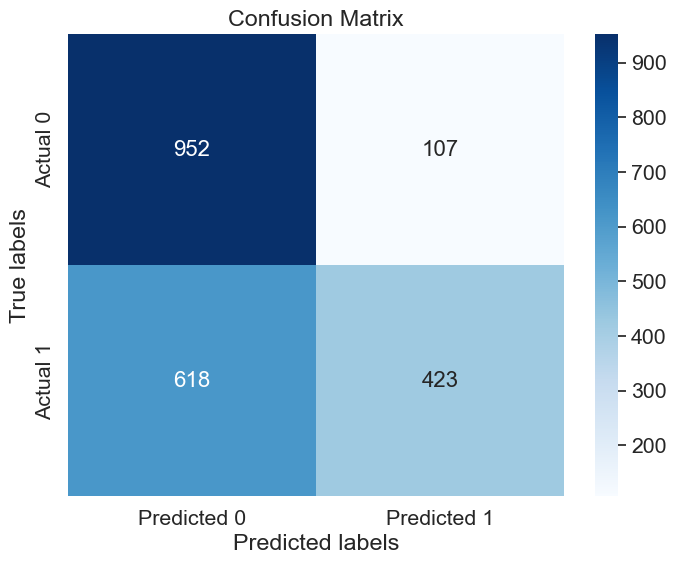

In [ ]:
print('Training')
compute_metrics(train_labels,train_preds)
print('Validation')
compute_metrics(val_labels,val_preds)

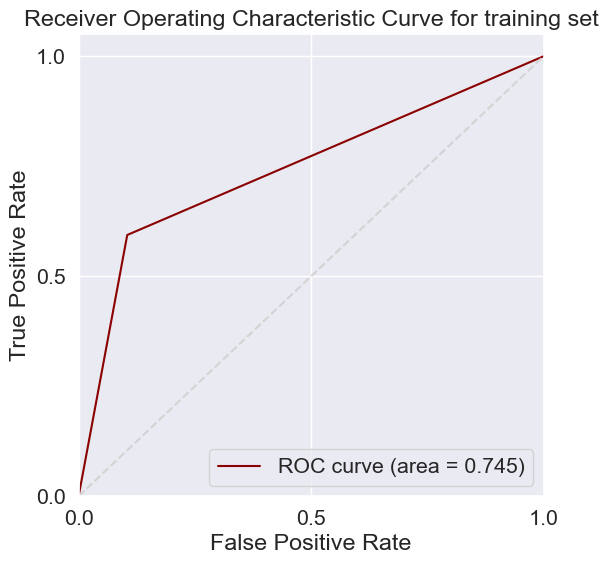

In [ ]:
# --- Link prediction ---
train_preds, test_preds = prediction(svm_l,train_features,train_labels, test_features)
logistic_pred = zip(np.array(range(len(test_set))), test_preds)
with open('./Predictions/SVMLinear.csv',"w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in logistic_pred:
         csv_out.writerow(row)
    pred.close()

### 3.3 - SVM Polynomial

In [ ]:
# Model SVC
svm_p= SVC(kernel='poly')

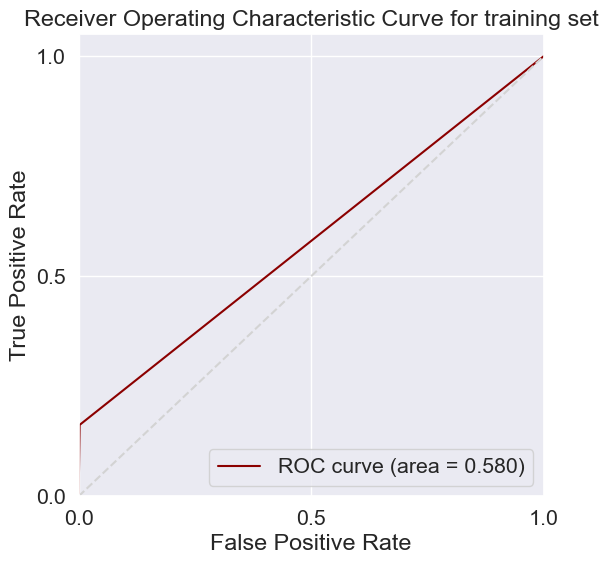

Accuracy:  0.559047619047619
Precision:  0.967479674796748
Recall:  0.1143131604226705
F1:  0.20446735395189003
Confusion matrix:  [[1055    4]
 [ 922  119]]


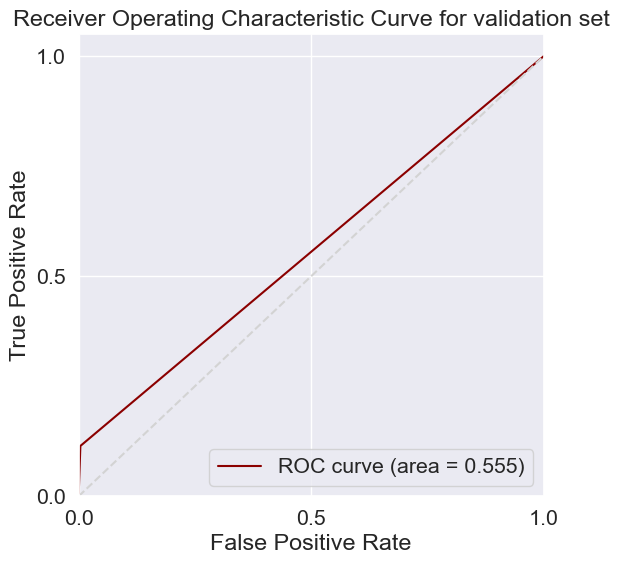

In [ ]:
train_preds, val_preds = prediction( svm_p , train_features_residual, train_labels, val_features_residual, val_labels)

Training
 Set Metrics:
Accuracy: 0.579, Precision: 0.987, Recall: 0.162, F1 Score: 0.278, ROC AUC: 0.580


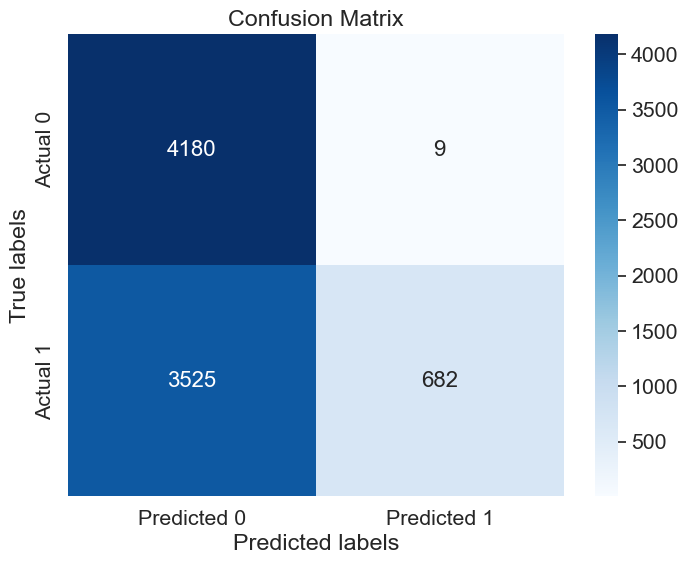

Validation
 Set Metrics:
Accuracy: 0.559, Precision: 0.967, Recall: 0.114, F1 Score: 0.204, ROC AUC: 0.555


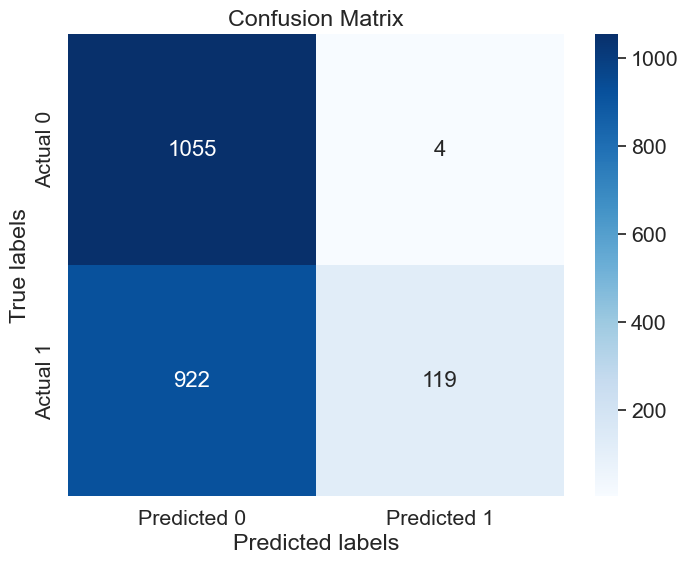

In [ ]:
print('Training')
compute_metrics(train_labels,train_preds)
print('Validation')
compute_metrics(val_labels,val_preds)

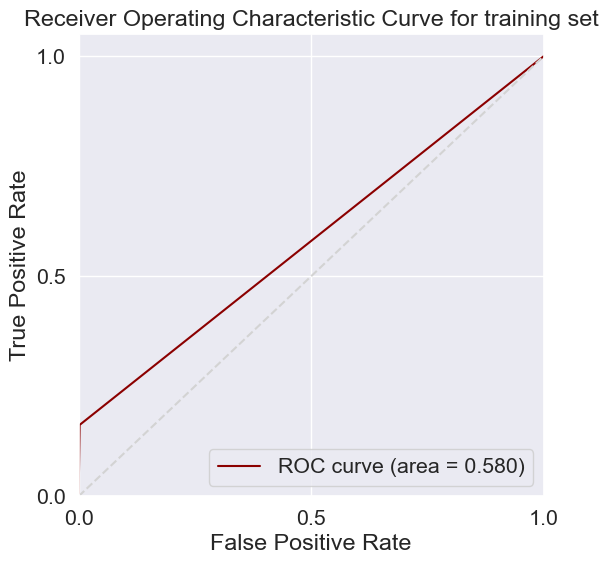

In [ ]:
# --- Link prediction ---
train_preds, test_preds = prediction(svm_p,train_features,train_labels, test_features)
logistic_pred = zip(np.array(range(len(test_set))), test_preds)
with open('./Predictions/SVMPoly.csv',"w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in logistic_pred:
         csv_out.writerow(row)
    pred.close()

### 3.3 - SVM Gaussian

In [ ]:
# Model SVC
svm_rbf= SVC(kernel='rbf')

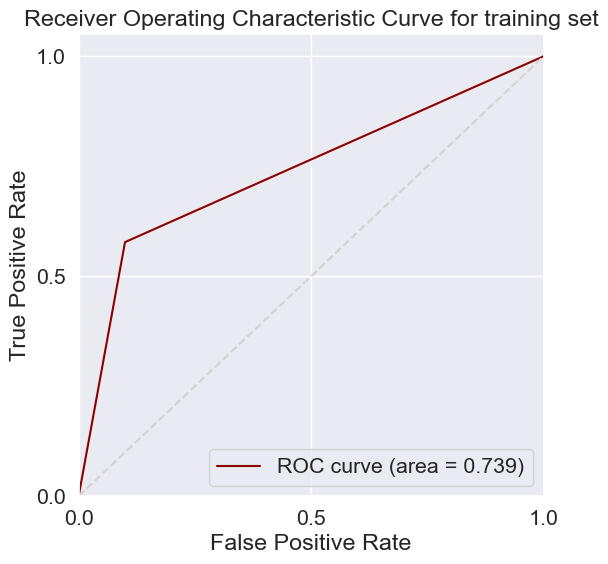

Accuracy:  0.6457142857142857
Precision:  0.7940594059405941
Recall:  0.3852065321805956
F1:  0.51875808538163
Confusion matrix:  [[955 104]
 [640 401]]


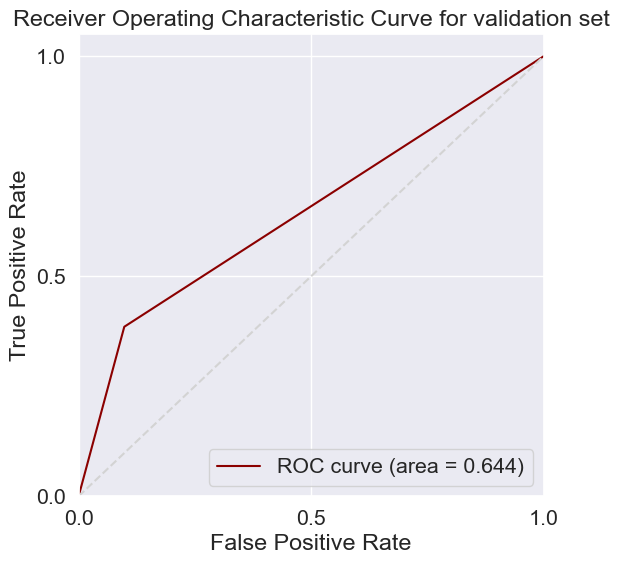

In [ ]:
train_preds, val_preds = prediction( svm_rbf , train_features_residual, train_labels, val_features_residual, val_labels)

Training
 Set Metrics:
Accuracy: 0.739, Precision: 0.853, Recall: 0.578, F1 Score: 0.689, ROC AUC: 0.739


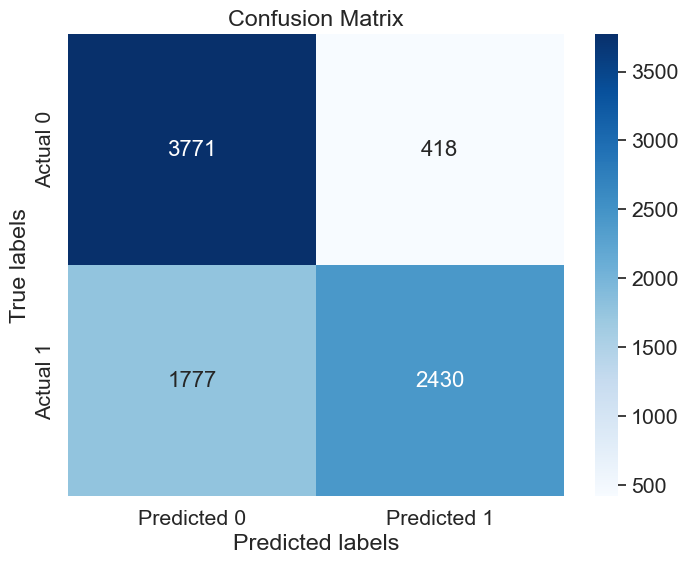

Validation
 Set Metrics:
Accuracy: 0.646, Precision: 0.794, Recall: 0.385, F1 Score: 0.519, ROC AUC: 0.644


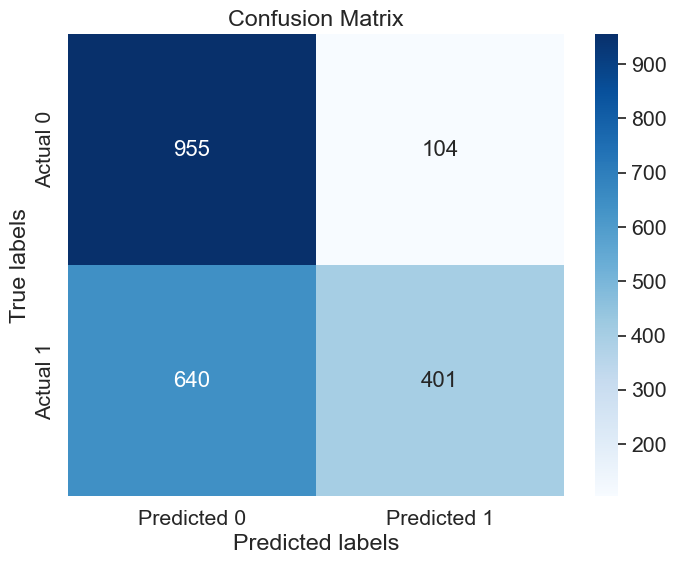

In [ ]:
print('Training')
compute_metrics(train_labels,train_preds)
print('Validation')
compute_metrics(val_labels,val_preds)

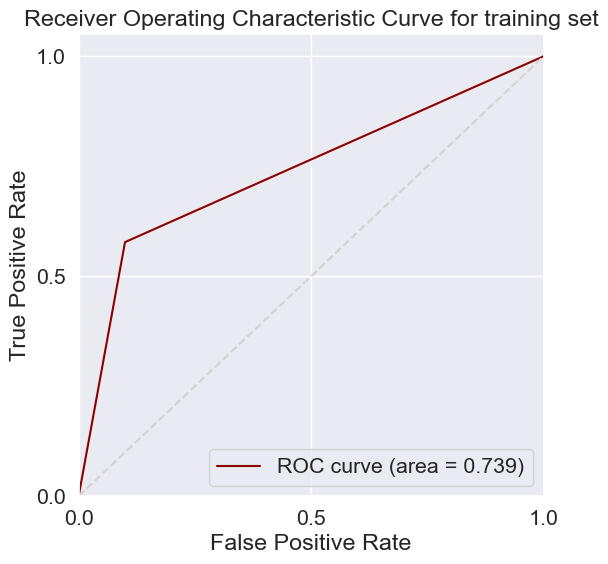

In [ ]:
# --- Link prediction ---
train_preds, test_preds = prediction(svm_rbf,train_features,train_labels, test_features)
logistic_pred = zip(np.array(range(len(test_set))), test_preds)
with open('./Predictions/SVMGaussian.csv',"w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in logistic_pred:
         csv_out.writerow(row)
    pred.close()

## 3.4 - SAGE et GCN

#### 1. Create Train, Val and Test Dataset

In [ ]:
from sklearn.preprocessing import StandardScaler
from torch_geometric.loader import NeighborLoader, LinkNeighborLoader, LinkLoader, NodeLoader

In [378]:
x = torch.tensor(node_information.values, dtype=torch.float)

# Convert labels to PyTorch tensor
y_train = torch.tensor([[1 if label == 0 else 0, 1 if label == 1 else 0] for label in train_labels], dtype=torch.long)
y_val = torch.tensor([[1 if label == 0 else 0, 1 if label == 1 else 0] for label in val_labels], dtype=torch.long)

# Convert edge indices to PyTorch tensor
edge_index_train = torch.tensor(train_samples,dtype=torch.long).transpose(0, 1)
edge_index_val = torch.tensor(val_samples, dtype=torch.long).transpose(0,1)
edge_index_test = torch.tensor(test_samples, dtype=torch.long).transpose(0,1)

# create edge features
edge_attr_train = torch.tensor(train_features_residual, dtype=torch.float)
edge_attr_val = torch.tensor(val_features_residual, dtype=torch.float)
edge_attr_test = torch.tensor(test_features, dtype=torch.float)


In [65]:
# Create Data objects for train and validation sets
data_train = Data(x=x, edge_index=edge_index_train , edge_attr= edge_attr_train,y=y_train)
data_val = Data(x=x, edge_index=edge_index_val, edge_attr = edge_attr_val ,y=y_val)

# # create dataloader for train et val
batch_size = 32
train_data_loader = NeighborLoader(data_train, num_neighbors=[-1], batch_size=batch_size, shuffle=True)
val_data_loader = NeighborLoader(data_val, num_neighbors=[-1], batch_size=batch_size, shuffle=True)


#### 2. Model Definition

In [66]:
from torch_geometric.nn import GCNConv
class GATModel(nn.Module):
  def __init__(self, input_size, hidden_size, hidden_size_bis, output_size_embed, nb_edge_features):
    super().__init__()
    # self.conv1 = GATv2Conv(input_size, hidden_size, heads=6)
    # self.conv2 = GATv2Conv(6 * hidden_size, hidden_size, heads=4)
    # self.conv3 = GATv2Conv(4 * hidden_size, hidden_size_bis, heads=4)
    # self.conv4 = GATv2Conv(4 * hidden_size_bis, output_size_embed, heads=6, concat=False)

    # self.conv1 = SAGEConv(input_size, hidden_size, aggr="max")
    # self.conv2 = SAGEConv(hidden_size, hidden_size_bis, aggr="mean")
    # self.conv3 = SAGEConv(hidden_size_bis, hidden_size_bis//2, aggr="max")
    # self.conv4 = SAGEConv(hidden_size_bis//2, hidden_size_bis//2, aggr="mean")
    # self.conv5 = SAGEConv(hidden_size_bis//2, output_size_embed, aggr="max")

    self.conv1 = GCNConv(input_size, hidden_size)
    self.conv2 = GCNConv(hidden_size, hidden_size_bis)
    self.conv3 = GCNConv(hidden_size_bis, hidden_size_bis//2)
    self.conv4 = GCNConv(hidden_size_bis//2, hidden_size_bis//2)
    self.conv5 = GCNConv(hidden_size_bis//2, output_size_embed)

    self.lin1 = nn.Linear(2 * output_size_embed + nb_edge_features, output_size_embed)
    self.lin2 = nn.Linear(output_size_embed, output_size_embed)
    self.lin3 = nn.Linear(output_size_embed, output_size_embed//2)
    self.lin4 = nn.Linear(output_size_embed//2, 2)

  def forward(self, x, edge_index, edge_attr):
    x = self.conv1(x, edge_index)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.conv2(x, edge_index)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.conv3(x, edge_index)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.conv4(x, edge_index)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.conv5(x, edge_index)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)

    row, col = edge_index

    x = torch.cat([x[row], x[col], edge_attr], dim=1)
    x = self.lin1(x)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.lin2(x)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.lin3(x)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.lin4(x)

    return x

In [67]:
def evaluate(model, loss_fcn, device, dataloader):
    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index, batch.edge_attr)
        loss_test = loss_fcn(output, batch.y.float())
        predict = np.where(output.detach().cpu().numpy()[:, 1] >= 0, 1, 0)
        score = accuracy_score(batch.y.cpu().numpy()[:, 1], predict)
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

In [68]:
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader, scheduler = None):

    epoch_list = []
    scores_list = []
    all_losses= []
    best_model_state_dict = None
    best_score = 0

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []

        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            output = model(train_batch_device.x, train_batch_device.edge_index, train_batch_device.edge_attr)
            # compute the loss
            loss = loss_fcn(output, train_batch_device.y.float())
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        loss_data = np.array(losses).mean()
        all_losses.append(loss_data)
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if scheduler is not None:
            scheduler.step()

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("Accuracy Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)
            # Check if the current model is the best one so far
            if score > best_score:
                best_score = score
                best_model_state_dict = model.state_dict()
    # Load the best model parameters
    if best_model_state_dict is not None:
        model.load_state_dict(best_model_state_dict)
    return epoch_list, scores_list, all_losses


#### 4. Training

In [69]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

# Create the GAT model
model = GATModel(input_size=x.shape[1], hidden_size=500, hidden_size_bis=400, output_size_embed=300, nb_edge_features=data_train.num_edge_features).to(device)

# Define the loss function and optimizer
loss_fcn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

max_epochs=10


Device:  cpu


In [70]:
best_model_state_dict = None
best_score = 0
train_losses = []
test_losses = []
# Initialize with a low value if accuracy is the metric# Train without mini-batches
data_train_device = data_train.to(device)
data_val_device = data_val.to(device)

for epoch in range(max_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data_train_device.x, data_train_device.edge_index, data_train_device.edge_attr)
    loss = loss_fcn(out, data_train_device.y.float())
    loss.backward()
    optimizer.step()

    print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss.item()))

    train_losses.append(loss.item())

    model.eval()
    output = model(data_val_device.x, data_val_device.edge_index, data_val_device.edge_attr)
    loss_test = loss_fcn(output, data_val_device.y.float())
    test_losses.append(loss_test.item())

    predict = np.where(output.detach().cpu().numpy()[:, 1] >= 0.5, 1, 0)
    score = accuracy_score(data_val_device.y.cpu().numpy()[:, 1], predict)
    print("Accuracy core: {:.4f}".format(score))
    # Check if the current model is the best one so far
    if score > best_score:
        best_score = score
        best_model_state_dict = model.state_dict()

# Load the best model parameters
if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)

Epoch 00001 | Loss: 0.7188
Accuracy core: 0.5805
Epoch 00002 | Loss: 0.6265
Accuracy core: 0.6271
Epoch 00003 | Loss: 0.5970
Accuracy core: 0.6348
Epoch 00004 | Loss: 0.5795
Accuracy core: 0.6386
Epoch 00005 | Loss: 0.5576
Accuracy core: 0.6362
Epoch 00006 | Loss: 0.5343
Accuracy core: 0.6314
Epoch 00007 | Loss: 0.5336
Accuracy core: 0.6338
Epoch 00008 | Loss: 0.5354
Accuracy core: 0.6376
Epoch 00009 | Loss: 0.5239
Accuracy core: 0.6371
Epoch 00010 | Loss: 0.5274
Accuracy core: 0.6414


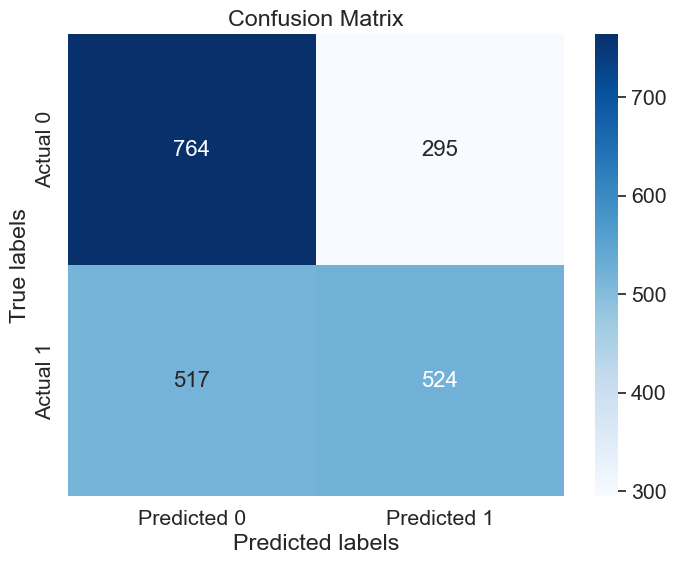

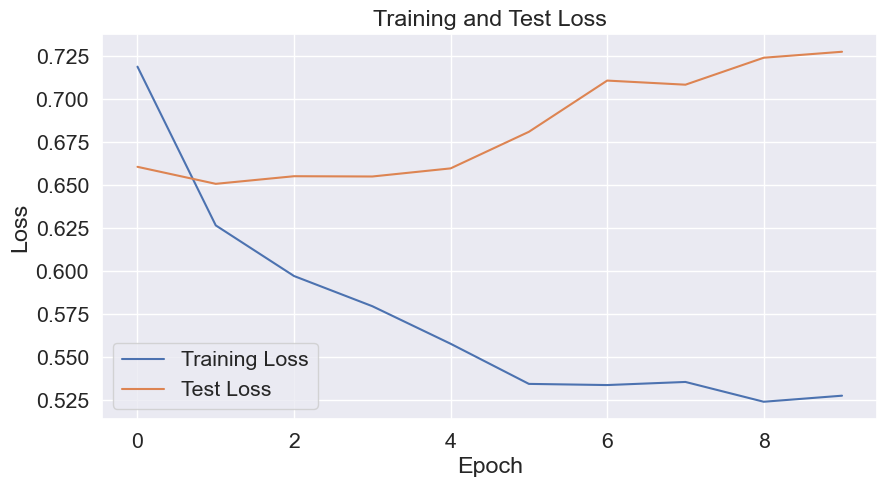

In [71]:
val_output = model(data_val_device.x, data_val_device.edge_index, data_val_device.edge_attr)
val_preds = np.where(val_output.detach().cpu().numpy() >= 0, 1, 0)[:, 1]
true_labels = torch.argmax(data_val_device.y.float(), dim=1).cpu().numpy()# Générer la matrice de confusion
conf_matrix = confusion_matrix(true_labels, val_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
# Plot both training and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Train on both val and train before submission

#### 5- Create Train, Val and Test Dataset

In [72]:
x = torch.tensor(node_information.values, dtype=torch.float)

# Convert labels to PyTorch tensor
y_train = torch.tensor([[1 if label == 0 else 0, 1 if label == 1 else 0] for label in train_labels], dtype=torch.long)
y_val = torch.tensor([[1 if label == 0 else 0, 1 if label == 1 else 0] for label in val_labels], dtype=torch.long)

# Convert edge indices to PyTorch tensor
edge_index_train = torch.tensor(train_samples,dtype=torch.long).transpose(0, 1)
edge_index_val = torch.tensor(val_samples, dtype=torch.long).transpose(0,1)
edge_index_test = torch.tensor(test_samples, dtype=torch.long).transpose(0,1)

# create edge features
edge_attr_train = torch.tensor(train_features, dtype=torch.float)
edge_attr_val = torch.tensor(val_features, dtype=torch.float)
edge_attr_test = torch.tensor(test_features, dtype=torch.float)


In [73]:
# Create Data objects for train and validation sets
data_train = Data(x=x, edge_index=edge_index_train , edge_attr= edge_attr_train,y=y_train)
data_val = Data(x=x, edge_index=edge_index_val, edge_attr = edge_attr_val ,y=y_val)

# # create dataloader for train et val
batch_size = 32
train_data_loader = NeighborLoader(data_train, num_neighbors=[-1], batch_size=batch_size, shuffle=True)
val_data_loader = NeighborLoader(data_val, num_neighbors=[-1], batch_size=batch_size, shuffle=True)


In [74]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

# Create the GAT model
model = GATModel(input_size=x.shape[1], hidden_size=500, hidden_size_bis=400, output_size_embed=300, nb_edge_features=data_train.num_edge_features).to(device)

# Define the loss function and optimizer
loss_fcn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

max_epochs=10


Device:  cpu


In [75]:
best_model_state_dict = None
best_score = 0

# Train without mini-batches
data_train_device = data_train.to(device)
data_val_device = data_val.to(device)
# fusionner les 2 datasets

data = torch.cat([data_train_device.x, data_val_device.x], dim=0)
edge_index = torch.cat([data_train_device.edge_index, data_val_device.edge_index], dim=1)
edge_attr = torch.cat([data_train_device.edge_attr, data_val_device.edge_attr], dim=0)
y = torch.cat([data_train_device.y, data_val_device.y], dim=0)

for epoch in range(max_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data, edge_index, edge_attr)
    predict = np.where(out.detach().cpu().numpy()[:, 1] >= 0.5, 1, 0)
    score = accuracy_score(y.cpu().numpy()[:, 1], predict)
    loss = loss_fcn(out,y.float())
    loss.backward()
    optimizer.step()


    print("Epoch {:05d} | Loss: {:.4f}| Accuracy: {:.4f}".format(epoch + 1, loss.item(), score))

    if score > best_score:
        best_score = score
        best_model_state_dict = model.state_dict()

# Load the best model parameters
if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)
    out = model(data, edge_index, edge_attr)
    predict = np.where(out.detach().cpu().numpy()[:, 1] >= 0.5, 1, 0)
    score = accuracy_score(y.cpu().numpy()[:, 1], predict)
    print(f'Accuracy of : {score}')

Epoch 00001 | Loss: 0.7623| Accuracy: 0.5683
Epoch 00002 | Loss: 0.6201| Accuracy: 0.6914
Epoch 00003 | Loss: 0.5919| Accuracy: 0.7307
Epoch 00004 | Loss: 0.5717| Accuracy: 0.7342
Epoch 00005 | Loss: 0.5441| Accuracy: 0.7170
Epoch 00006 | Loss: 0.5423| Accuracy: 0.6987
Epoch 00007 | Loss: 0.5503| Accuracy: 0.6984
Epoch 00008 | Loss: 0.5349| Accuracy: 0.7172
Epoch 00009 | Loss: 0.5377| Accuracy: 0.7354
Epoch 00010 | Loss: 0.5403| Accuracy: 0.7426
Accuracy of : 0.7402820121951219


#### 5.  Create submission

In [76]:
model.eval()
output = model(x.to(device), edge_index_test.to(device),edge_attr_test.to(device)  )
pred_test = np.where(output.detach().cpu().numpy() >= 0, 1, 0)[:, 1]

In [74]:
import os
import csv
preds = zip(np.array(range(len(test_set))), pred_test)
os.makedirs("models", exist_ok=True)
i = len(os.listdir("models")) +1
model_path = f"Predictions/GCN_best_model{i}.csv"

with open(model_path,"w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in preds:
         csv_out.writerow(row)
    pred.close()
